# Importing Libraries

In [1]:
import pandas as pd 
import numpy as np
import os

import warnings
warnings.filterwarnings("ignore")

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
import plotly.express as px

import random
from math import ceil
random.seed(42)

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

from sklearn.ensemble import ExtraTreesRegressor

from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
import pickle

In [2]:
train_folder = 'train'
test_folder = 'test'
dataset_folder = 'dataset'

# Loading Data

In [25]:
path_to_incoming_run = os.path.join(dataset_folder, 'incoming_run_data.parquet')
if not os.path.exists(path_to_incoming_run):
    print("File does not exist, creating a new one.")
    incoming_run_files = [f for f in os.listdir(train_folder) if 'incoming_run_data' in f]
    incoming_dataframes = []
    previous_run_id_list = []

    for files in incoming_run_files:
        temp_df = pd.read_parquet(os.path.join(train_folder, files))
        print(temp_df["Tool ID"].unique())

        run_id_list = temp_df["Run ID"].unique().tolist()

        if any(run_id in previous_run_id_list for run_id in run_id_list):
            print("Duplicate Run ID found in previous_run_id_list")
        
        previous_run_id_list.extend(run_id_list)
        incoming_dataframes.append(temp_df)

    incoming_df = pd.concat(incoming_dataframes, ignore_index=True)

    incoming_df.to_parquet('dataset/incoming_run_data.parquet', index=False)
else:
    print("File already exists, loading the existing one.")
    incoming_df = pd.read_parquet(path_to_incoming_run)

incoming_df

File already exists, loading the existing one.


Tool ID      Run Start Time  \
0         d7291410-f34f-5cee-b3a1-0c60bb854423 2023-12-31 00:00:00   
1         d7291410-f34f-5cee-b3a1-0c60bb854423 2023-12-31 00:00:00   
2         d7291410-f34f-5cee-b3a1-0c60bb854423 2023-12-31 00:00:00   
3         d7291410-f34f-5cee-b3a1-0c60bb854423 2023-12-31 00:00:00   
4         d7291410-f34f-5cee-b3a1-0c60bb854423 2023-12-31 00:00:00   
...                                        ...                 ...   
82896501  a060c807-dbdb-5de3-9cd7-0c596234a3d7 2024-01-03 23:43:15   
82896502  a060c807-dbdb-5de3-9cd7-0c596234a3d7 2024-01-03 23:43:15   
82896503  a060c807-dbdb-5de3-9cd7-0c596234a3d7 2024-01-03 23:43:15   
82896504  a060c807-dbdb-5de3-9cd7-0c596234a3d7 2024-01-03 23:43:15   
82896505  a060c807-dbdb-5de3-9cd7-0c596234a3d7 2024-01-03 23:43:15   

                Run End Time                                Run ID  \
0        2023-12-31 00:12:22  630ce06e-efcd-5473-9d2a-859f43908b8f   
1        2023-12-31 00:12:22  630ce06e-efcd-5473-9d2a-859f43908b8f   
2        2023-12-31 00:12:22  630ce06e-efcd-5473-9d2a-859f43908b8f   
3        2023-12-31 00:12:22  630ce06e-efcd-5473-9d2a-859f43908b8f   
4        2023-12-31 00:12:22  630ce06e-efcd-5473-9d2a-859f43908b8f   
...                      ...                                   ...   
82896501 2024-01-03 23:55:50  6908f294-5178-50bc-ba5b-5293435ba574   
82896502 2024-01-03 23:55:50  6908f294-5178-50bc-ba5b-5293435ba574   
82896503 2024-01-03 23:55:50  6908f294-5178-50bc-ba5b-5293435ba574   
82896504 2024-01-03 23:55:50  6908f294-5178-50bc-ba5b-5293435ba574   
82896505 2024-01-03 23:55:50  6908f294-5178-50bc-ba5b-5293435ba574   

                                  Process Step Step ID  \
0         22c8716b-1c14-525a-8c0a-0473ec7aa99e  Step_0   
1         22c8716b-1c14-525a-8c0a-0473ec7aa99e  Step_0   
2         22c8716b-1c14-525a-8c0a-0473ec7aa99e  Step_0   
3         22c8716b-1c14-525a-8c0a-0473ec7aa99e  Step_1   
4         22c8716b-1c14-525a-8c0a-0473ec7aa99e  Step_1   
...                                        ...     ...   
82896501  22c8716b-1c14-525a-8c0a-0473ec7aa99e  Step_7   
82896502  22c8716b-1c14-525a-8c0a-0473ec7aa99e  Step_7   
82896503  22c8716b-1c14-525a-8c0a-0473ec7aa99e  Step_7   
82896504  22c8716b-1c14-525a-8c0a-0473ec7aa99e  Step_7   
82896505  22c8716b-1c14-525a-8c0a-0473ec7aa99e  Step_7   

                            Time Stamp Sensor Name  Sensor Value  
0        2023-12-31 00:00:00.000000000    Sensor_1    195.469116  
1        2023-12-31 00:00:01.000000002    Sensor_1    195.497040  
2        2023-12-31 00:00:01.999999997    Sensor_1    195.497025  
3        2023-12-31 00:00:03.000000000    Sensor_1    195.474823  
4        2023-12-31 00:00:04.000000002    Sensor_1    195.496368  
...                                ...         ...           ...  
82896501 2024-01-03 23:51:09.000000000    Sensor_9      2.702956  
82896502 2024-01-03 23:51:10.000000002    Sensor_9      2.957552  
82896503 2024-01-03 23:51:10.999999998    Sensor_9     -0.477442  
82896504 2024-01-03 23:51:12.000000000    Sensor_9     -1.214340  
82896505 2024-01-03 23:51:13.000000002    Sensor_9     -2.170303  

[82896506 rows x 9 columns]

In [46]:
# incoming_df_filtereddd = incoming_df[(incoming_df['Tool ID']=="ad28cd71-3811-543c-80a1-a440468a49d7") & (incoming_df['Run ID']=="83b60d06-30f0-5ed5-a1d4-9fd0bd50a71b")]
# incoming_df_filtereddd

In [9]:
path_to_run = os.path.join(dataset_folder, 'run_data.parquet')
if not os.path.exists(path_to_run):
    print("File does not exist, creating a new one.")
    run_files = [f for f in os.listdir(train_folder) if 'run_data' in f and 'incoming' not in f]
    run_dataframes = []
    previous_run_id_list = []

    for files in run_files:
        temp_df = pd.read_parquet(os.path.join(train_folder, files))
        print(temp_df["Tool ID"].unique())

        run_id_list = temp_df["Run ID"].unique().tolist()

        if any(run_id in previous_run_id_list for run_id in run_id_list):
            print("Duplicate Run ID found in previous_run_id_list")
        
        previous_run_id_list.extend(run_id_list)
        run_dataframes.append(temp_df)

    run_df = pd.concat(run_dataframes, ignore_index=True)

    run_df.to_parquet('dataset/run_data.parquet', index=False)

else:
    print("File already exists, loading the existing one.")
    run_df = pd.read_parquet(path_to_run)

run_df

File already exists, loading the existing one.


Tool ID      Run Start Time  \
0         30476bd4-f093-56c9-8cd1-23cf7f39ce5f 2024-01-01 00:00:00   
1         30476bd4-f093-56c9-8cd1-23cf7f39ce5f 2024-01-01 00:00:00   
2         30476bd4-f093-56c9-8cd1-23cf7f39ce5f 2024-01-01 00:00:00   
3         30476bd4-f093-56c9-8cd1-23cf7f39ce5f 2024-01-01 00:00:00   
4         30476bd4-f093-56c9-8cd1-23cf7f39ce5f 2024-01-01 00:00:00   
...                                        ...                 ...   
41220745  ad28cd71-3811-543c-80a1-a440468a49d7 2024-01-04 04:38:15   
41220746  ad28cd71-3811-543c-80a1-a440468a49d7 2024-01-04 04:38:15   
41220747  ad28cd71-3811-543c-80a1-a440468a49d7 2024-01-04 04:38:15   
41220748  ad28cd71-3811-543c-80a1-a440468a49d7 2024-01-04 04:38:15   
41220749  ad28cd71-3811-543c-80a1-a440468a49d7 2024-01-04 04:38:15   

                Run End Time                                Run ID  \
0        2024-01-01 00:12:35  c749278a-b1a4-5062-a57e-45e4946f6b78   
1        2024-01-01 00:12:35  c749278a-b1a4-5062-a57e-45e4946f6b78   
2        2024-01-01 00:12:35  c749278a-b1a4-5062-a57e-45e4946f6b78   
3        2024-01-01 00:12:35  c749278a-b1a4-5062-a57e-45e4946f6b78   
4        2024-01-01 00:12:35  c749278a-b1a4-5062-a57e-45e4946f6b78   
...                      ...                                   ...   
41220745 2024-01-04 04:50:50  84a6fa0a-721c-576c-97f6-1f5bfe46de4a   
41220746 2024-01-04 04:50:50  84a6fa0a-721c-576c-97f6-1f5bfe46de4a   
41220747 2024-01-04 04:50:50  84a6fa0a-721c-576c-97f6-1f5bfe46de4a   
41220748 2024-01-04 04:50:50  84a6fa0a-721c-576c-97f6-1f5bfe46de4a   
41220749 2024-01-04 04:50:50  84a6fa0a-721c-576c-97f6-1f5bfe46de4a   

                                  Process Step  Consumable Life  Step ID  \
0         22c8716b-1c14-525a-8c0a-0473ec7aa99e       199.290131   Step_0   
1         22c8716b-1c14-525a-8c0a-0473ec7aa99e       199.290131   Step_0   
2         22c8716b-1c14-525a-8c0a-0473ec7aa99e       199.290131   Step_1   
3         22c8716b-1c14-525a-8c0a-0473ec7aa99e       199.290131   Step_1   
4         22c8716b-1c14-525a-8c0a-0473ec7aa99e       199.290131   Step_1   
...                                        ...              ...      ...   
41220745  22c8716b-1c14-525a-8c0a-0473ec7aa99e        67.854195  Step_12   
41220746  22c8716b-1c14-525a-8c0a-0473ec7aa99e        67.854195  Step_12   
41220747  22c8716b-1c14-525a-8c0a-0473ec7aa99e        67.854195  Step_12   
41220748  22c8716b-1c14-525a-8c0a-0473ec7aa99e        67.854195  Step_12   
41220749  22c8716b-1c14-525a-8c0a-0473ec7aa99e        67.854195  Step_12   

                            Time Stamp Sensor Name  Sensor Value  
0        2024-01-01 00:00:00.000000000    Sensor_A     -0.024998  
1        2024-01-01 00:00:01.000000002    Sensor_A      0.073171  
2        2024-01-01 00:00:01.999999997    Sensor_A      0.070384  
3        2024-01-01 00:00:03.000000000    Sensor_A      0.064502  
4        2024-01-01 00:00:04.000000002    Sensor_A     -0.097807  
...                                ...         ...           ...  
41220745 2024-01-04 04:48:06.000000000    Sensor_O    775.952576  
41220746 2024-01-04 04:48:07.000000002    Sensor_O    771.639465  
41220747 2024-01-04 04:48:07.999999998    Sensor_O    774.632263  
41220748 2024-01-04 04:48:09.000000000    Sensor_O    774.416626  
41220749 2024-01-04 04:48:10.000000002    Sensor_O    773.337219  

[41220750 rows x 10 columns]

In [22]:
path_to_metrology = os.path.join(dataset_folder, 'metrology_data.parquet')
if not os.path.exists(path_to_metrology):
    print("File does not exist, creating a new one.")
    metrology_files = [f for f in os.listdir(train_folder) if 'metrology_data' in f]

    # Read and concatenate all parquet files
    metrology_dataframes = [pd.read_parquet(os.path.join(train_folder, file)) for file in metrology_files]
    metrology_df = pd.concat(metrology_dataframes, ignore_index=True)

    metrology_df.to_parquet('dataset/metrology_data.parquet', index=False)
else: 
    print("File already exists, loading the existing one.")
    metrology_df = pd.read_parquet(path_to_metrology)

metrology_df

File already exists, loading the existing one.


Run ID      Run Start Time  \
0       00970470-f2f4-5759-86c4-f31fe6abdc5a 2024-01-01 04:41:20   
1       00970470-f2f4-5759-86c4-f31fe6abdc5a 2024-01-01 04:41:20   
2       00970470-f2f4-5759-86c4-f31fe6abdc5a 2024-01-01 04:41:20   
3       00970470-f2f4-5759-86c4-f31fe6abdc5a 2024-01-01 04:41:20   
4       00970470-f2f4-5759-86c4-f31fe6abdc5a 2024-01-01 04:41:20   
...                                      ...                 ...   
202855  ff189126-dd33-50b0-8eea-5bab9318b543 2024-01-01 11:43:20   
202856  ff189126-dd33-50b0-8eea-5bab9318b543 2024-01-01 11:43:20   
202857  ff189126-dd33-50b0-8eea-5bab9318b543 2024-01-01 11:43:20   
202858  ff189126-dd33-50b0-8eea-5bab9318b543 2024-01-01 11:43:20   
202859  ff189126-dd33-50b0-8eea-5bab9318b543 2024-01-01 11:43:20   

              Run End Time  X_index  Y_index           X          Y  \
0      2024-01-01 04:53:55        1       23 -143.877551  -9.183673   
1      2024-01-01 04:53:55        1       29 -143.877551  27.551020   
2      2024-01-01 04:53:55        2       34 -137.755102  58.163265   
3      2024-01-01 04:53:55        3       14 -131.632653 -64.285714   
4      2024-01-01 04:53:55        5       39 -119.387755  88.775510   
...                    ...      ...      ...         ...        ...   
202855 2024-01-01 11:55:55       44       11  119.387755 -82.653061   
202856 2024-01-01 11:55:55       44       39  119.387755  88.775510   
202857 2024-01-01 11:55:55       46       26  131.632653   9.183673   
202858 2024-01-01 11:55:55       48       21  143.877551 -21.428571   
202859 2024-01-01 11:55:55       48       31  143.877551  39.795918   

        Point Index  Measurement  
0                 3    10.104178  
1                48    10.064924  
2                43    10.039947  
3                20    10.139306  
4                 8    10.037289  
...             ...          ...  
202855            5    10.141212  
202856           22    10.285743  
202857           46    10.305865  
202858           16    10.325929  
202859            2    10.373255  

[202860 rows x 9 columns]

# Data Visualisation

In [53]:
count = 0
incoming_run_id_list = []
unique_tool_ids = incoming_df['Tool ID'].unique()

for tool_id in unique_tool_ids[:6]:  # Limit to first 5 tools for visualization
    # Get first run ID for each tool
    run_id = incoming_df[incoming_df['Tool ID'] == tool_id]['Run ID'].iloc[0]
    incoming_run_id_list.append([tool_id, run_id])

# Get unique sensor names
sensor_names = incoming_df["Sensor Name"].unique()
num_sensors = len(sensor_names)

# Limit to first 6 (tool_id, run_id) pairs for subplots
n_subplots = 6
subplot_pairs = incoming_run_id_list[:n_subplots]

for sensor in sensor_names:
    fig = make_subplots(rows=3, cols=2, subplot_titles=[
        f"Tool: {tool_id}<br>Run: {run_id}" for tool_id, run_id in subplot_pairs
    ])
    
    # Define a color map for steps (consistent across all graphs)
    all_step_ids = sorted(incoming_df["Step ID"].unique(), key=lambda x: int(x.split('_')[-1]))
    color_map = {
        step: px.colors.qualitative.Plotly[i % len(px.colors.qualitative.Plotly)]
        for i, step in enumerate(all_step_ids)
    }

    # Track which steps have been added to legend
    legend_steps = set()
    
    for idx, (tool_id, run_id) in enumerate(subplot_pairs):
        temp_df = incoming_df[(incoming_df["Tool ID"] == tool_id) & (incoming_df["Run ID"] == run_id)]
        time_start = temp_df["Time Stamp"].min()
        sensor_df = temp_df[temp_df["Sensor Name"] == sensor]
        
        row = idx // 2 + 1
        col = idx % 2 + 1

        for step in all_step_ids:
            step_data = sensor_df[sensor_df["Step ID"] == step]
            if not step_data.empty:
                time_elapsed = (step_data["Time Stamp"] - time_start).dt.total_seconds()
                
                # Show in legend only if this step hasn't been shown before
                show_legend = step not in legend_steps
                legend_steps.add(step)
                
                fig.add_trace(
                    go.Scatter(
                        x=time_elapsed,
                        y=step_data["Sensor Value"],
                        name=step,
                        mode='lines',
                        line=dict(color=color_map[step]),
                        showlegend=show_legend
                    ),
                    row=row,
                    col=col
                )
    
    fig.update_layout(
        height=1400,
        width=1500,
        title_text=f"Sensor: {sensor} - Comparison Across Tools/Runs",
        showlegend=True
    )

    fig.write_html(os.path.join('plots', 'sensor_readings', f'{sensor}.html'))

    if count < 1:
        fig.show()
        count += 1

In [54]:
# count = 0
# incoming_run_id_list = []
# unique_tool_ids = incoming_df['Tool ID'].unique()

# for tool_id in unique_tool_ids[:5]:  # Limit to first 3 tools for visualization
#     # Get first run ID for each tool
#     run_id = incoming_df[incoming_df['Tool ID'] == tool_id]['Run ID'].iloc[0]
#     incoming_run_id_list.append([tool_id, run_id])

# for tool_id, run_id in incoming_run_id_list:
#     print(f"Tool ID: {tool_id}, Run ID: {run_id}")
#     temp_df = incoming_df[(incoming_df["Tool ID"] == tool_id) & (incoming_df["Run ID"] == run_id)]
#     time_start = temp_df["Time Stamp"].min()
    
#     # Get unique sensor names for this run
#     sensor_names = temp_df["Sensor Name"].unique()
    
#     for sensor in sensor_names:
#         sensor_df = temp_df[temp_df["Sensor Name"] == sensor]
        
#         # Create figure
#         fig = go.Figure()
        
#         # Plot each step
#         for step in sensor_df["Step ID"].unique():
#             step_data = sensor_df[sensor_df["Step ID"] == step]
#             time_elapsed = (step_data["Time Stamp"] - time_start).dt.total_seconds()
            
#             fig.add_trace(go.Scatter(
#                 x=time_elapsed,
#                 y=step_data["Sensor Value"],
#                 name=step,
#                 mode='lines'
#             ))
        
#         fig.update_layout(
#             title=f'Tool ID: {tool_id}, Run ID: {run_id}, Sensor: {sensor}',
#             xaxis_title='Time (seconds)',
#             yaxis_title='Sensor Value',
#             legend_title='Step ID',
#             showlegend=True
#         )

#         os.makedirs(os.path.join('plots', 'sensor_readings', sensor), exist_ok=True)
#         fig.write_html(os.path.join('plots', 'sensor_readings', f'{sensor}', f'{run_id}.html'))

#         if count < 6:
#             fig.show()
#             count += 1

In [55]:
count = 0
run_id_list = []
unique_tool_ids_run = run_df['Tool ID'].unique()

for tool_id in unique_tool_ids_run[:6]:  # Limit to first 5 tools for visualization
    # Get first run ID for each tool
    run_id = run_df[run_df['Tool ID'] == tool_id]['Run ID'].iloc[0]
    run_id_list.append([tool_id, run_id])

# Get unique sensor names
sensor_names = run_df["Sensor Name"].unique()
num_sensors = len(sensor_names)

for sensor in sensor_names:
    fig = make_subplots(rows=3, cols=2, subplot_titles=[
        f"Tool: {tool_id}<br>Run: {run_id}" for tool_id, run_id in subplot_pairs
    ])
    
    # Define a color map for steps (consistent across all graphs)
    all_step_ids = sorted(run_df["Step ID"].unique(), key=lambda x: int(x.split('_')[-1]))
    color_map = {
        step: px.colors.qualitative.Plotly[i % len(px.colors.qualitative.Plotly)]
        for i, step in enumerate(all_step_ids)
    }

    # Track which steps have been added to legend
    legend_steps = set()
    
    for idx, (tool_id, run_id) in enumerate(subplot_pairs):
        temp_df = run_df[(run_df["Tool ID"] == tool_id) & (run_df["Run ID"] == run_id)]
        time_start = temp_df["Time Stamp"].min()
        sensor_df = temp_df[temp_df["Sensor Name"] == sensor]
        
        row = idx // 2 + 1
        col = idx % 2 + 1

        for step in all_step_ids:
            step_data = sensor_df[sensor_df["Step ID"] == step]
            if not step_data.empty:
                time_elapsed = (step_data["Time Stamp"] - time_start).dt.total_seconds()
                
                # Show in legend only if this step hasn't been shown before
                show_legend = step not in legend_steps
                legend_steps.add(step)
                
                fig.add_trace(
                    go.Scatter(
                        x=time_elapsed,
                        y=step_data["Sensor Value"],
                        name=step,
                        mode='lines',
                        line=dict(color=color_map[step]),
                        showlegend=show_legend
                    ),
                    row=row,
                    col=col
                )
    
    fig.update_layout(
        height=1400,
        width=1500,
        title_text=f"Sensor: {sensor} - Comparison Across Tools/Runs",
        showlegend=True
    )

    fig.write_html(os.path.join('plots', 'sensor_readings', f'{sensor}.html'))

    if count < 1:
        fig.show()
        count += 1

# Data Processing

## 1. Incoming Run Data

### Finding Average Sensor Values

In [14]:
def average_incoming_data(incoming_df):
    tmp_list = []

    temp_grps = [(x[0], x[1], x[2], x[3], y) for x, y in incoming_df.groupby(by=["Tool ID", "Run ID", "Step ID", "Sensor Name"])]
    for temp_grp in temp_grps:
        temp_tool_id = temp_grp[0]
        temp_run_id = temp_grp[1]
        temp_step_id = temp_grp[2]
        temp_sensor_name = temp_grp[3]
        temp_df = temp_grp[4]
        temp_df = temp_df.reset_index()

        temp_run_start_time = temp_df.loc[0, "Run Start Time"]
        temp_run_end_time = temp_df.loc[0, "Run End Time"]
        temp_process_step = temp_df.loc[0, "Process Step"]

        sensor_avgs = temp_df["Sensor Value"].mean()

        temp_time_taken = (temp_df["Time Stamp"].max() - temp_df["Time Stamp"].min()).total_seconds()
        temp_time_taken = int(round(temp_time_taken))
    
        tmp_list.append([
            temp_process_step,
            temp_tool_id,
            temp_run_id,
            temp_run_start_time,
            temp_run_end_time,
            temp_time_taken,
            temp_step_id,
            temp_sensor_name,
            sensor_avgs
        ]) 

    columns = [
        "Process Step",
        "Tool ID",
        "Run ID",
        "Run Start Time",
        "Run End Time",
        "Time Taken (Seconds)",
        "Step ID",
        "Sensor Name",
        "Sensor Value (Average)"
    ] 
    
    incoming_avg_df = pd.DataFrame(tmp_list, columns=columns) 
    del temp_grps
    incoming_avg_df = incoming_avg_df.sort_values(
        by=["Step ID", "Sensor Name"], 
        key=lambda x: x.str.extract(r'_(\d+)')[0].astype(int)
    )

    incoming_avg_df["Test"] = incoming_avg_df["Sensor Name"] + ";" + incoming_avg_df["Step ID"]
    incoming_avg_df = incoming_avg_df.drop(columns=["Step ID", "Sensor Name"])

    return incoming_avg_df

In [15]:
incoming_avg_df = average_incoming_data(incoming_df)

incoming_avg_df.to_parquet('processed/incoming_avg_df.parquet', index=False)

incoming_avg_df

NameError: name 'incoming_df' is not defined

In [ ]:
incoming_avg_df = pd.read_parquet('processed/incoming_avg_df.parquet')
incoming_avg_df

### Pivot Dataframe

In [ ]:
def pivot_incoming_data(incoming_avg_df):    
    dataframe_incoming_pivot = incoming_avg_df.pivot(
        index=["Process Step", "Tool ID", "Run ID", "Run Start Time", "Run End Time"],
        columns="Test",
        values="Sensor Value (Average)"
    ).reset_index()

    return dataframe_incoming_pivot

In [ ]:
dataframe_incoming_pivot = pivot_incoming_data(incoming_avg_df)

dataframe_incoming_pivot.to_parquet('processed/dataframe_incoming_pivot.parquet', index=False)

dataframe_incoming_pivot.sort_values(by=["Run End Time"])

## 2. Run Data

### Finding Average Sensor Values

In [ ]:
def average_run_data(run_df):
    tmp_list = []

    temp_grps = [(x[0], x[1], x[2], x[3], y) for x, y in run_df.groupby(by=["Tool ID", "Run ID", "Step ID", "Sensor Name"])]
    for temp_grp in temp_grps:
        temp_tool_id = temp_grp[0]
        temp_run_id = temp_grp[1]
        temp_step_id = temp_grp[2]
        temp_sensor_name = temp_grp[3]
        temp_df = temp_grp[4]
        temp_df = temp_df.reset_index()

        temp_run_start_time = temp_df.loc[0, "Run Start Time"]
        temp_run_end_time = temp_df.loc[0, "Run End Time"]
        temp_process_step = temp_df.loc[0, "Process Step"]
        temp_consumable_life = temp_df.loc[0, "Consumable Life"]

        sensor_avgs = temp_df["Sensor Value"].mean()

        temp_time_taken = (temp_df["Time Stamp"].max() - temp_df["Time Stamp"].min()).total_seconds()
        temp_time_taken = int(round(temp_time_taken))
    
        tmp_list.append([
            temp_process_step,
            temp_tool_id,
            temp_run_id,
            temp_run_start_time,
            temp_run_end_time,
            temp_time_taken,
            temp_consumable_life,
            temp_step_id,
            temp_sensor_name,
            sensor_avgs
        ]) 

    columns = [
        "Process Step",
        "Tool ID",
        "Run ID",
        "Run Start Time",
        "Run End Time",
        "Time Taken (Seconds)",
        "Consumable Life",
        "Step ID",
        "Sensor Name",
        "Sensor Value (Average)"
    ] 
    
    run_avg_df = pd.DataFrame(tmp_list, columns=columns) 
    del temp_grps
    run_avg_df = run_avg_df.sort_values(
        by=["Step ID"], 
        key=lambda x: x.str.extract(r'Step_(\d+)')[0].astype(int)
    )

    run_avg_df["Test"] = run_avg_df["Sensor Name"] + ";" + run_avg_df["Step ID"]
    run_avg_df = run_avg_df.drop(columns=["Step ID", "Sensor Name"])

    return run_avg_df

In [ ]:
run_avg_df = average_run_data(run_df)

run_avg_df.to_parquet('processed/run_avg_df.parquet', index=False)

run_avg_df

In [ ]:
run_avg_df = pd.read_parquet('processed/run_avg_df.parquet')
run_avg_df.sort_values(by=["Run ID"])

Process Step  \
225065  22c8716b-1c14-525a-8c0a-0473ec7aa99e   
660319  22c8716b-1c14-525a-8c0a-0473ec7aa99e   
660328  22c8716b-1c14-525a-8c0a-0473ec7aa99e   
224943  22c8716b-1c14-525a-8c0a-0473ec7aa99e   
660330  22c8716b-1c14-525a-8c0a-0473ec7aa99e   
...                                      ...   
299214  22c8716b-1c14-525a-8c0a-0473ec7aa99e   
299213  22c8716b-1c14-525a-8c0a-0473ec7aa99e   
299212  22c8716b-1c14-525a-8c0a-0473ec7aa99e   
299242  22c8716b-1c14-525a-8c0a-0473ec7aa99e   
430745  22c8716b-1c14-525a-8c0a-0473ec7aa99e   

                                     Tool ID  \
225065  e4838ac1-3788-50bf-bbca-04cf339ec369   
660319  e4838ac1-3788-50bf-bbca-04cf339ec369   
660328  e4838ac1-3788-50bf-bbca-04cf339ec369   
224943  e4838ac1-3788-50bf-bbca-04cf339ec369   
660330  e4838ac1-3788-50bf-bbca-04cf339ec369   
...                                      ...   
299214  4738fd3d-8fc7-59fd-85a7-eec6efb4bfae   
299213  4738fd3d-8fc7-59fd-85a7-eec6efb4bfae   
299212  4738fd3d-8fc7-59fd-85a7-eec6efb4bfae   
299242  4738fd3d-8fc7-59fd-85a7-eec6efb4bfae   
430745  4738fd3d-8fc7-59fd-85a7-eec6efb4bfae   

                                      Run ID      Run Start Time  \
225065  000f424f-667d-54a2-bbbd-9624c4071465 2024-01-01 18:47:35   
660319  000f424f-667d-54a2-bbbd-9624c4071465 2024-01-01 18:47:35   
660328  000f424f-667d-54a2-bbbd-9624c4071465 2024-01-01 18:47:35   
224943  000f424f-667d-54a2-bbbd-9624c4071465 2024-01-01 18:47:35   
660330  000f424f-667d-54a2-bbbd-9624c4071465 2024-01-01 18:47:35   
...                                      ...                 ...   
299214  fff1bbfa-cec2-5e98-a434-794e060a2227 2024-01-02 20:02:00   
299213  fff1bbfa-cec2-5e98-a434-794e060a2227 2024-01-02 20:02:00   
299212  fff1bbfa-cec2-5e98-a434-794e060a2227 2024-01-02 20:02:00   
299242  fff1bbfa-cec2-5e98-a434-794e060a2227 2024-01-02 20:02:00   
430745  fff1bbfa-cec2-5e98-a434-794e060a2227 2024-01-02 20:02:00   

              Run End Time  Time Taken (Seconds)  Consumable Life  \
225065 2024-01-01 19:00:10                    36       270.084137   
660319 2024-01-01 19:00:10                    11       270.084137   
660328 2024-01-01 19:00:10                    11       270.084137   
224943 2024-01-01 19:00:10                    36       270.084137   
660330 2024-01-01 19:00:10                    11       270.084137   
...                    ...                   ...              ...   
299214 2024-01-02 20:14:35                    27       153.919037   
299213 2024-01-02 20:14:35                    27       153.919037   
299212 2024-01-02 20:14:35                    27       153.919037   
299242 2024-01-02 20:14:35                    27       153.919037   
430745 2024-01-02 20:14:35                    37       153.919037   

        Sensor Value (Average)              Test  
225065                0.004345   Sensor_D;Step_3  
660319              106.681671  Sensor_C;Step_10  
660328             1018.618652  Sensor_O;Step_10  
224943              505.508484   Sensor_J;Step_3  
660330              988.464355  Sensor_N;Step_10  
...                        ...               ...  
299214             1277.189453   Sensor_M;Step_4  
299213                6.522406   Sensor_L;Step_4  
299212               23.902121   Sensor_K;Step_4  
299242             4931.753906   Sensor_D;Step_4  
430745               -0.006167   Sensor_A;Step_6  

[807300 rows x 9 columns]

### Pivot Dataframe

In [ ]:
def pivot_run_data(run_avg_df):
    dataframe_run_pivot = run_avg_df.pivot(
        index=["Process Step", "Tool ID", "Run ID", "Run Start Time", "Run End Time", "Consumable Life"],
        columns="Test",
        values="Sensor Value (Average)"
    ).reset_index()

    return dataframe_run_pivot

In [ ]:
dataframe_run_pivot = pivot_run_data(run_avg_df)

dataframe_run_pivot.to_parquet('processed/dataframe_run_pivot.parquet', index=False)

dataframe_run_pivot.sort_values(by=["Run End Time"])

## 3. Merging Data

In [ ]:
def merge_dataframes(metrology_df, dataframe_run_pivot, dataframe_incoming_pivot):
    final_df = pd.DataFrame()
    unique_run_ids = metrology_df["Run ID"].unique().tolist()

    for run_id in unique_run_ids:
        temp_metrology_df = metrology_df[metrology_df["Run ID"] == run_id].reset_index(drop=True)
        temp_run_df = dataframe_run_pivot[dataframe_run_pivot["Run ID"] == run_id].reset_index(drop=True)
        temp_incoming_df = dataframe_incoming_pivot[dataframe_incoming_pivot["Run ID"] == run_id].reset_index(drop=True)

        temp_incoming_df = temp_incoming_df.drop(columns=["Run Start Time", "Run End Time"])

        if temp_run_df.empty:
            print(f"Run ID {run_id} not found in run data.")
            continue

        if temp_incoming_df.empty:
            print(f"Run ID {run_id} not found in incoming data.")
            continue

        for _, metrology_row in temp_metrology_df.iterrows():
            # Convert row Series to single-row DataFrame
            metrology_row_df = pd.DataFrame([metrology_row])
            
            # Merge with corresponding run data
            merge_1 = pd.merge(
                metrology_row_df,
                temp_run_df,
                how="left",
                on=["Run ID", "Run Start Time", "Run End Time"]
            )

            merge_2 = pd.merge(
                merge_1,
                temp_incoming_df,
                how="left",
                on=["Process Step", "Tool ID", "Run ID"]
            )

            # Append to the result DataFrame
            final_df = pd.concat([final_df, merge_2], ignore_index=True)

    return final_df

In [ ]:
final_df = merge_dataframes(metrology_df, dataframe_run_pivot, dataframe_incoming_pivot)

final_df.to_parquet('processed/final_df.parquet', index=False)

In [ ]:
final_df = pd.read_parquet('processed/final_df.parquet')
final_df

Run ID      Run Start Time  \
0       00970470-f2f4-5759-86c4-f31fe6abdc5a 2024-01-01 04:41:20   
1       00970470-f2f4-5759-86c4-f31fe6abdc5a 2024-01-01 04:41:20   
2       00970470-f2f4-5759-86c4-f31fe6abdc5a 2024-01-01 04:41:20   
3       00970470-f2f4-5759-86c4-f31fe6abdc5a 2024-01-01 04:41:20   
4       00970470-f2f4-5759-86c4-f31fe6abdc5a 2024-01-01 04:41:20   
...                                      ...                 ...   
202855  ff189126-dd33-50b0-8eea-5bab9318b543 2024-01-01 11:43:20   
202856  ff189126-dd33-50b0-8eea-5bab9318b543 2024-01-01 11:43:20   
202857  ff189126-dd33-50b0-8eea-5bab9318b543 2024-01-01 11:43:20   
202858  ff189126-dd33-50b0-8eea-5bab9318b543 2024-01-01 11:43:20   
202859  ff189126-dd33-50b0-8eea-5bab9318b543 2024-01-01 11:43:20   

              Run End Time  X_index  Y_index           X          Y  \
0      2024-01-01 04:53:55        1       23 -143.877551  -9.183673   
1      2024-01-01 04:53:55        1       29 -143.877551  27.551020   
2      2024-01-01 04:53:55        2       34 -137.755102  58.163265   
3      2024-01-01 04:53:55        3       14 -131.632653 -64.285714   
4      2024-01-01 04:53:55        5       39 -119.387755  88.775510   
...                    ...      ...      ...         ...        ...   
202855 2024-01-01 11:55:55       44       11  119.387755 -82.653061   
202856 2024-01-01 11:55:55       44       39  119.387755  88.775510   
202857 2024-01-01 11:55:55       46       26  131.632653   9.183673   
202858 2024-01-01 11:55:55       48       21  143.877551 -21.428571   
202859 2024-01-01 11:55:55       48       31  143.877551  39.795918   

        Point Index  Measurement                          Process Step  ...  \
0                 3    10.104178  22c8716b-1c14-525a-8c0a-0473ec7aa99e  ...   
1                48    10.064924  22c8716b-1c14-525a-8c0a-0473ec7aa99e  ...   
2                43    10.039947  22c8716b-1c14-525a-8c0a-0473ec7aa99e  ...   
3                20    10.139306  22c8716b-1c14-525a-8c0a-0473ec7aa99e  ...   
4                 8    10.037289  22c8716b-1c14-525a-8c0a-0473ec7aa99e  ...   
...             ...          ...                                   ...  ...   
202855            5    10.141212  22c8716b-1c14-525a-8c0a-0473ec7aa99e  ...   
202856           22    10.285743  22c8716b-1c14-525a-8c0a-0473ec7aa99e  ...   
202857           46    10.305865  22c8716b-1c14-525a-8c0a-0473ec7aa99e  ...   
202858           16    10.325929  22c8716b-1c14-525a-8c0a-0473ec7aa99e  ...   
202859            2    10.373255  22c8716b-1c14-525a-8c0a-0473ec7aa99e  ...   

       Sensor_8;Step_6  Sensor_8;Step_7  Sensor_9;Step_0  Sensor_9;Step_1  \
0            50.465588        52.934277        41.957478       147.698120   
1            50.465588        52.934277        41.957478       147.698120   
2            50.465588        52.934277        41.957478       147.698120   
3            50.465588        52.934277        41.957478       147.698120   
4            50.465588        52.934277        41.957478       147.698120   
...                ...              ...              ...              ...   
202855       49.780426        52.448387        26.414335       126.463196   
202856       49.780426        52.448387        26.414335       126.463196   
202857       49.780426        52.448387        26.414335       126.463196   
202858       49.780426        52.448387        26.414335       126.463196   
202859       49.780426        52.448387        26.414335       126.463196   

        Sensor_9;Step_2  Sensor_9;Step_3  Sensor_9;Step_4  Sensor_9;Step_5  \
0             91.161613       131.187378       102.621956       103.496384   
1             91.161613       131.187378       102.621956       103.496384   
2             91.161613       131.187378       102.621956       103.496384   
3             91.161613       131.187378       102.621956       103.496384   
4             91.161613       131.187378       102.621956       103.496384   
...                 ...   

# Data Splitting

Since we want to generalise across tools, we will split by tool ID 

In [4]:
target = 'Measurement'
non_features = ["Run ID", "Run Start Time", "Run End Time", "X_index", "Y_index", "Point Index", "Process Step", "Tool ID"]

selected_features = [col for col in final_df.columns if col not in [target] + non_features]
print(selected_features)
print(len(selected_features))

['X', 'Y', 'Consumable Life', 'Sensor_A;Step_0', 'Sensor_A;Step_1', 'Sensor_A;Step_10', 'Sensor_A;Step_11', 'Sensor_A;Step_12', 'Sensor_A;Step_2', 'Sensor_A;Step_3', 'Sensor_A;Step_4', 'Sensor_A;Step_5', 'Sensor_A;Step_6', 'Sensor_A;Step_7', 'Sensor_A;Step_8', 'Sensor_A;Step_9', 'Sensor_B;Step_0', 'Sensor_B;Step_1', 'Sensor_B;Step_10', 'Sensor_B;Step_11', 'Sensor_B;Step_12', 'Sensor_B;Step_2', 'Sensor_B;Step_3', 'Sensor_B;Step_4', 'Sensor_B;Step_5', 'Sensor_B;Step_6', 'Sensor_B;Step_7', 'Sensor_B;Step_8', 'Sensor_B;Step_9', 'Sensor_C;Step_0', 'Sensor_C;Step_1', 'Sensor_C;Step_10', 'Sensor_C;Step_11', 'Sensor_C;Step_12', 'Sensor_C;Step_2', 'Sensor_C;Step_3', 'Sensor_C;Step_4', 'Sensor_C;Step_5', 'Sensor_C;Step_6', 'Sensor_C;Step_7', 'Sensor_C;Step_8', 'Sensor_C;Step_9', 'Sensor_D;Step_0', 'Sensor_D;Step_1', 'Sensor_D;Step_10', 'Sensor_D;Step_11', 'Sensor_D;Step_12', 'Sensor_D;Step_2', 'Sensor_D;Step_3', 'Sensor_D;Step_4', 'Sensor_D;Step_5', 'Sensor_D;Step_6', 'Sensor_D;Step_7', 'Sensor_

In [5]:
tool_id_list = final_df["Tool ID"].unique().tolist()
validation_id_list = random.sample(tool_id_list, k=ceil(len(tool_id_list) * 0.2))
train_id_list = list(set(tool_id_list) - set(validation_id_list))

print("Number of Tool IDs used for training:", len(train_id_list))
print("Number of Tool IDs used for validation:", len(validation_id_list))

Number of Tool IDs used for training: 15
Number of Tool IDs used for validation: 4


In [6]:
train_df = final_df[final_df["Tool ID"].isin(train_id_list)].reset_index()
validation_df = final_df[final_df["Tool ID"].isin(validation_id_list)].reset_index()

print("Length of training data:", len(train_df))
print("Length of validation data:", len(validation_df))

Length of training data: 158760
Length of validation data: 44100


In [7]:
X_train = train_df[selected_features]
y_train = train_df[target]

X_validation = validation_df[selected_features]
y_validation = validation_df[target]

print("X train shape:", X_train.shape)
print("y train shape:", y_train.shape)

print("X validate shape:", X_validation.shape)
print("y validate shape:", y_validation.shape)

X train shape: (158760, 526)
y train shape: (158760,)
X validate shape: (44100, 526)
y validate shape: (44100,)


# Feature Selection

## Extra Trees Feature Importance 

Selected Features: ['X' 'Y' 'Sensor_N;Step_1' 'Sensor_N;Step_11' 'Sensor_N;Step_5'
 'Sensor_N;Step_8' 'Sensor_I;Step_1' 'Sensor_N;Step_7' 'Sensor_I;Step_2'
 'Sensor_N;Step_6' 'Sensor_N;Step_9' 'Sensor_I;Step_11' 'Sensor_I;Step_9'
 'Sensor_N;Step_2' 'Sensor_N;Step_4' 'Sensor_B;Step_9' 'Sensor_I;Step_3'
 'Sensor_I;Step_6' 'Sensor_I;Step_4' 'Sensor_I;Step_8' 'Sensor_B;Step_4'
 'Sensor_N;Step_0' 'Sensor_N;Step_10' 'Sensor_I;Step_5' 'Sensor_I;Step_7'
 'Sensor_I;Step_10' 'Sensor_K;Step_2' 'Sensor_M;Step_1' 'Sensor_M;Step_5'
 'Sensor_H;Step_4' 'Sensor_M;Step_9' 'Sensor_E;Step_2' 'Sensor_M;Step_2'
 'Sensor_M;Step_8' 'Sensor_M;Step_7' 'Sensor_M;Step_4' 'Sensor_H;Step_1'
 'Sensor_H;Step_11' 'Sensor_M;Step_3' 'Sensor_H;Step_8' 'Sensor_G;Step_5'
 'Sensor_M;Step_11' 'Sensor_1;Step_6' 'Sensor_G;Step_4' 'Sensor_1;Step_5'
 'Consumable Life']


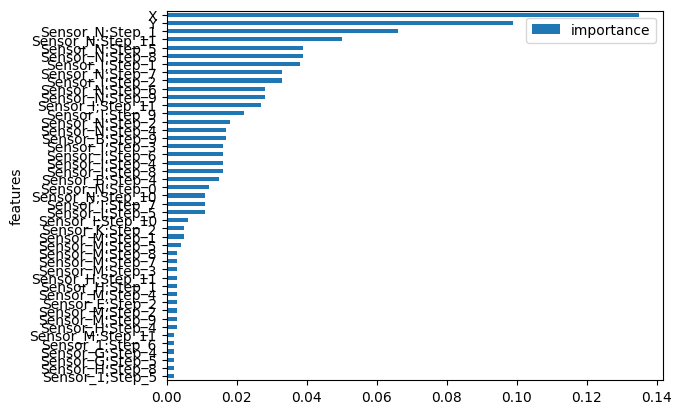

In [8]:
def extra_trees_feature_selection(X, y, top_k: int = 45):
    model = ExtraTreesRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    
    feature_importances = model.feature_importances_
    
    importance_df = pd.DataFrame({
        'features': X.columns,
        'importance': feature_importances
    }).sort_values(by='importance', ascending=False).reset_index(drop=True).round(3).head(top_k)
    
    selected_features = importance_df['features'].values
    
    return selected_features, importance_df

selected_features, top_k_df = extra_trees_feature_selection(X_train, y_train, top_k=45)
length = len(selected_features)

additional_features = ['X', 'Y', 'Consumable Life']
for feature in additional_features:
    if feature not in selected_features:
        selected_features = np.append(selected_features, feature)

print("Selected Features:", selected_features)

X_train = X_train[selected_features]
X_validation = X_validation[selected_features]

top_k_df.sort_values(by='importance', ascending=True).plot.barh(y='importance', x='features')
plt.savefig(f'plots/feature_importance_extra_trees-{length}.png', bbox_inches='tight')

## Select K Best

In [9]:
# def select_k_best_regression(X, Y, top_k: int = 40):
#     model = SelectKBest(score_func=f_regression, k=top_k)  
#     model.fit(X, Y)
#     scores = model.scores_
#     col_names = X.columns

#     score_df = pd.DataFrame({
#         'features': col_names,
#         'scores': scores
#     }).sort_values(by='scores', ascending=False).reset_index(drop=True).round(3)

#     selected_features = score_df.head(top_k)['features'].values
#     return selected_features, score_df.head(top_k)

# selected_features, top_k_df = select_k_best_regression(final_df[selected_features], final_df[target], top_k=100)

# additional_features = ['X', 'Y', 'Consumable Life']
# for feature in additional_features:
#     if feature not in selected_features:
#         selected_features = np.append(selected_features, feature)

# print("Final Selected Features:", len(selected_features))

# print("Selected Features:", selected_features)
# top_k_df.sort_values(by='scores', ascending=True).plot.barh(y='scores', x='features')

## PCA 

In [12]:
# scaler = StandardScaler()
# feature_scaled = scaler.fit_transform(final_df[selected_features])

# pca_selected_feature = PCA(n_components=len(selected_features))
# pca_selected_feature.fit(feature_scaled)

# explained_variance = pca_selected_feature.explained_variance_ratio_ * 100

# plt.figure(figsize=(12, 6))
# plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--', color='black')
# plt.xlabel('Principal Component')

# for i, value in enumerate(explained_variance, start=1):
#     plt.text(i + 1, value + 0.5, f"{value:.1f}%", ha='center', fontsize=8)

# plt.ylabel('Explained Variance (%)')
# plt.title('PCA Scree Plot')
# plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, color='teal', label='Percentage')

# plt.xticks(range(1, len(explained_variance) + 1, 1))

# plt.grid(True)
# plt.legend()

# plt.savefig('plots/pca_scree_plot.png', bbox_inches='tight')
# plt.show()

In [ ]:
# variance = pca_selected_feature.explained_variance_ratio_ * 100
# cumulative_variance = np.cumsum(variance)

# min_pc = np.argmax(cumulative_variance >= 80) + 1

# print(f"Minimum number of principal components to explain 80% variance: {min_pc}")

Minimum number of principal components to explain 80% variance: 26


In [64]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(final_df[selected_features])

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Scatter plot for regression
fig = px.scatter(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    color=final_df[target],  # Continuous color
    title='PCA 2D Projection (Colored by Target Value)',
    labels={'x': 'PC 1', 'y': 'PC 2', 'color': 'Target'},
    color_continuous_scale='Viridis'  # or 'Plasma', 'Cividis', 'Turbo', etc.
)
fig.write_html(f'plots/pca_scatter_plot-{len(selected_features)}.html')
fig.show()

# Model Building and Training

## Models

### 1. Linear Regression

In [63]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validate_scaled = scaler.transform(X_validation)

# Train linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_validate_scaled)

### 2. Extra Trees Regressor

In [10]:
et_model = ExtraTreesRegressor(
    n_estimators=300,
    max_depth=20,
    criterion='squared_error',
    random_state=42,
    bootstrap=True
)

et_model.fit(X_train, y_train)
y_pred_et = et_model.predict(X_validation)

### 3. Multi Layer Perceptron

In [65]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validate_scaled = scaler.transform(X_validation)

mlp_model = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    learning_rate_init=0.001,
    max_iter=1000,
    random_state=42
)

mlp_model.fit(X_train_scaled, y_train)
y_pred_mlp = mlp_model.predict(X_validate_scaled)

## Model Initial Evaluation

### Comparing Model Performance 

In [11]:
print(X_train.shape)

(158760, 46)


In [12]:
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Evaluation:")
    print(f"R² Score: {r2_score(y_true, y_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")

# evaluate_model("Linear Regression", y_validation, y_pred_lr)
evaluate_model("Extra Trees Regressor", y_validation, y_pred_et)
# evaluate_model("Multi Layer Perceptron", y_validation, y_pred_mlp)


Extra Trees Regressor Evaluation:
R² Score: 0.9217
RMSE: 0.0489


### Error Distribution Plot

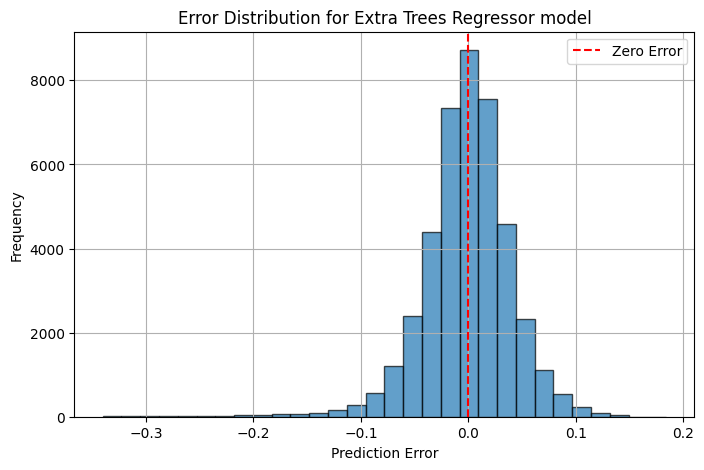

In [65]:
predictions = {
    # 'Linear Regression': y_pred_lr,
    'Extra Trees Regressor': y_pred_et,
    # 'Multi Layer Perceptron': y_pred_mlp
}

for name, preds in predictions.items():
    error = preds - y_validation

    plt.figure(figsize=(8, 5))
    plt.hist(error, bins=30, edgecolor='k', alpha=0.7)
    plt.title(f"Error Distribution for {name} model")
    plt.xlabel("Prediction Error")
    plt.ylabel("Frequency")
    plt.axvline(x=0, color='red', linestyle='--', label='Zero Error')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"plots/error_distribution_{name}-{len(selected_features)}.png")
    plt.show()

### REC Curve (Regression Error Characteristic)

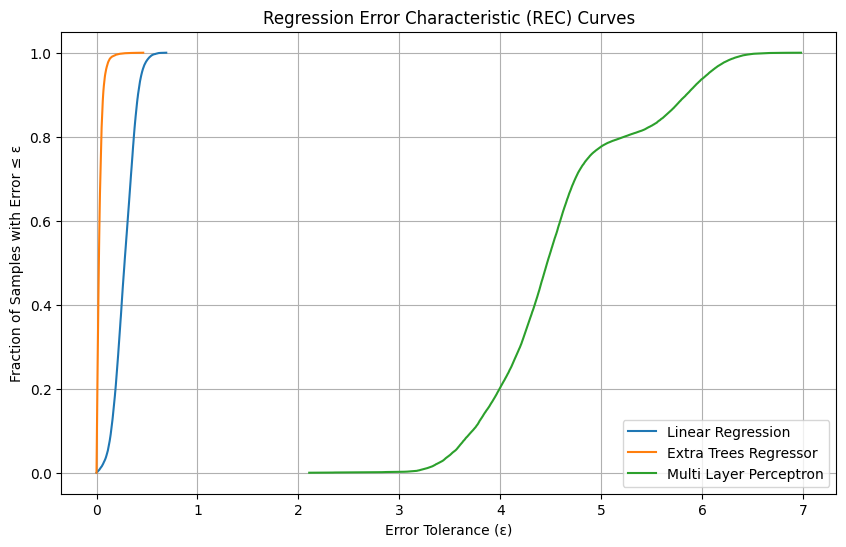

In [ ]:

# Plot the REC curve for all models on the same graph
plt.figure(figsize=(10, 6))

for name, preds in predictions.items():
    abs_errors = np.abs(preds - y_validation)
    sorted_errors = np.sort(abs_errors)
    coverage = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
    plt.plot(sorted_errors, coverage, label=name)

plt.xlabel("Error Tolerance (ε)")
plt.ylabel("Fraction of Samples with Error ≤ ε")
plt.title(f"Regression Error Characteristic (REC) Curves for {len(selected_features)}")
plt.grid(True)
plt.legend()
plt.savefig("plots/rec_curves.png")
plt.show()

# Model Optimisation

## Optuna Tuning

Doing optimisation for the best model

In [13]:
scorer = make_scorer(mean_squared_error, greater_is_better=False)

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 10, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    model = ExtraTreesRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42,
    )

    score = cross_val_score(model, X_train, y_train, cv=5, scoring=scorer).mean()
    return score

study = optuna.create_study(direction='maximize') 
study.optimize(objective, n_trials=25)

best_params = study.best_trial.params

print("Best trial:", best_params)

[I 2025-05-24 16:07:55,468] A new study created in memory with name: no-name-10a56f8a-2ea1-4cde-8fb0-cde35989329f
[I 2025-05-24 16:16:34,092] Trial 0 finished with value: -0.0024153794151028753 and parameters: {'n_estimators': 407, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 0 with value: -0.0024153794151028753.
[I 2025-05-24 16:23:48,386] Trial 1 finished with value: -0.0025027370718916286 and parameters: {'n_estimators': 361, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 0 with value: -0.0024153794151028753.
[I 2025-05-24 16:35:08,543] Trial 2 finished with value: -0.002308889193332998 and parameters: {'n_estimators': 311, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 2 with value: -0.002308889193332998.
[I 2025-05-24 16:43:29,107] Trial 3 finished with value: -0.002426129247767103 and parameters: {'n_estimators': 386, 'max_dep

Best trial: {'n_estimators': 197, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False}


In [16]:
best_model = ExtraTreesRegressor(
    **best_params,
    random_state=42
)

best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_validation)

evaluate_model("Optimized Extra Trees Regressor", y_validation, y_pred_best)
evaluate_model("Extra Trees Regressor", y_validation, y_pred_et)


Optimized Extra Trees Regressor Evaluation:
R² Score: 0.9255
RMSE: 0.0477

Extra Trees Regressor Evaluation:
R² Score: 0.9217
RMSE: 0.0489


In [17]:
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Model Results on Test Set

## Loading data

In [ ]:
incoming_test_df = pd.read_parquet('test/incoming_run_data.parquet')
incoming_test_df

In [ ]:
run_test_df = pd.read_parquet('test/run_data.parquet')
run_test_df

In [3]:
metrology_test_df = pd.read_parquet('submission/metrology_data.parquet')
metrology_test_df

Run ID      Run Start Time  \
0      03aa7486-bf62-5d59-b844-5f2d4a4528c4 2024-01-02 16:31:00   
1      03aa7486-bf62-5d59-b844-5f2d4a4528c4 2024-01-02 16:31:00   
2      03aa7486-bf62-5d59-b844-5f2d4a4528c4 2024-01-02 16:31:00   
3      03aa7486-bf62-5d59-b844-5f2d4a4528c4 2024-01-02 16:31:00   
4      03aa7486-bf62-5d59-b844-5f2d4a4528c4 2024-01-02 16:31:00   
...                                     ...                 ...   
42135  ef918e33-410b-5687-bb0c-ca086e995572 2024-01-04 01:24:50   
42136  ef918e33-410b-5687-bb0c-ca086e995572 2024-01-04 01:24:50   
42137  ef918e33-410b-5687-bb0c-ca086e995572 2024-01-04 01:24:50   
42138  ef918e33-410b-5687-bb0c-ca086e995572 2024-01-04 01:24:50   
42139  ef918e33-410b-5687-bb0c-ca086e995572 2024-01-04 01:24:50   

             Run End Time  X_index  Y_index           X          Y  \
0     2024-01-02 16:43:35        1       23 -143.877551  -9.183673   
1     2024-01-02 16:43:35        1       29 -143.877551  27.551020   
2     2024-01-02 16:43:35        2       34 -137.755102  58.163265   
3     2024-01-02 16:43:35        3       14 -131.632653 -64.285714   
4     2024-01-02 16:43:35        5       39 -119.387755  88.775510   
...                   ...      ...      ...         ...        ...   
42135 2024-01-04 01:37:25       44       11  119.387755 -82.653061   
42136 2024-01-04 01:37:25       44       39  119.387755  88.775510   
42137 2024-01-04 01:37:25       46       26  131.632653   9.183673   
42138 2024-01-04 01:37:25       48       21  143.877551 -21.428571   
42139 2024-01-04 01:37:25       48       31  143.877551  39.795918   

       Point Index  Measurement  
0                3          NaN  
1               48          NaN  
2               43          NaN  
3               20          NaN  
4                8          NaN  
...            ...          ...  
42135            5          NaN  
42136           22          NaN  
42137           46          NaN  
42138           16          NaN  
42139            2          NaN  

[42140 rows x 9 columns]

## Data Processing

In [ ]:
incoming_avg_df_test = average_incoming_data(incoming_test_df)
dataframe_incoming_pivot_test = pivot_incoming_data(incoming_avg_df_test)

run_avg_df_test = average_run_data(run_test_df)
dataframe_run_pivot_test = pivot_run_data(run_avg_df_test)

final_test_df = merge_dataframes(metrology_test_df, dataframe_run_pivot_test, dataframe_incoming_pivot_test)
final_test_df

## Applying Model

In [ ]:
X_test = final_test_df[features_to_use]

y_pred_test = best_model.predict(X_test)

In [ ]:
metrology_test_df['Measurement'] = y_pred_test
metrology_test_df.to_parquet('submission/metrology_data_filled.parquet', index=False)